# Week 5 - Regularization

**Student Name 1, Student Name 2**

## Aims

By the end of this notebook you will be able to 

>* perform regulized regression in sklearn
>* understand the role of tuning parameter(s)
>* use cross-validation for model tuning and comparison.

1. [Problem Definition and Setup](#setup)
2. [Exploratory Data Analysis](#eda)
3. [Baseline Model](#baseline)
4. [Ridge Regression](#ridge)
4. [Lasso Regression](#lasso)
4. [ElasticNet Regression](#elasticnet)

During workshops, you will complete the worksheets together in teams of 2-3, using **pair programming**. You should aim to switch roles between driver and navigator approximately every 15 minutes. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given.

---

# Problem Definition and Setup<a id='setup'></a>

## Packages

First, let's load some of the packages you wil need for this workshop (we will load others as we progress).

In [2]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

## User Defined Helper Functions

We will make use of the two helper functions. The first is identical to the one last week. The second one extract the coefficients and names (if required), plots the coefficients and returns a data frame. 

In [3]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should residual plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Observed vs Fitted values")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted values vs Residuals")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsq) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [4]:
def get_coefs(m, plot = False, feature_names = None, figsize = (5,5), figtitle = None, intercept = True):
    """Returns model coefficients in a data frame for a fitted linear model.
    
    Args:
        m: sklearn LinearRegression model object or pipeline with LinearRegression as final step
        plot: boolean value, should coefficients be plotted with error bars
        feature_names: list of feature names to use in the plot 
        figsize: tuple defining figure size
        figtitle: string defining figure title
        intercept: boolean value, should intercept be included in the plot
    """
    
    # Extract intercept and coefficients into a single array
    w = np.concatenate(([m[-1].intercept_] if isinstance(m, sklearn.pipeline.Pipeline) else [m.intercept_], 
                            m[-1].coef_ if isinstance(m, sklearn.pipeline.Pipeline) else m.coef_))
    # Extract name of features
    if feature_names is None:
        feature_names = m[:-1].get_feature_names_out() if isinstance(m, sklearn.pipeline.Pipeline) else m.feature_names_in_
    feature_names = np.concatenate((['intercept'], feature_names))
    # Create a data frame
    w_df = pd.DataFrame({'feature': feature_names, 'coef': w}).sort_values ("coef", ascending=False)

    if plot:
        if not intercept:
            w_df = w_df[w_df['feature'] != 'intercept']
        plt.figure(figsize=figsize)
        plt.barh(w_df['feature'], w_df['coef'])
        plt.ylabel('Features')
        plt.xlabel('Coefficient Value')
        plt.axvline(x=0, color=".5")
        if figtitle is not None:
            plt.title(figtitle)
        plt.grid()
        plt.show()
    
    return  w_df

## Data

The data for this week's workshop comes from the Elements of Statistical Learning textbook. The data originally come from a study by [Stamey et al. (1989)](https://www.sciencedirect.com/science/article/abs/pii/S002253471741175X)  in which they examined the relationship between the level of prostate-specific antigen (`psa`) and a number of clinical measures in men who were about to receive a prostatectomy. The variables are as follows,

* `lpsa` - log of the level of prostate-specific antigen
* `lcavol` - log cancer volume
* `lweight` - log prostate weight
* `age` - patient age
* `lbph` - log of the amount of benign prostatic hyperplasia
* `svi` - seminal vesicle invasion
* `lcp` - log of capsular penetration
* `gleason` - Gleason score
* `pgg45` - percent of Gleason scores 4 or 5
* `train` - test / train split used in ESL

These data are available in `prostate.csv`, which is included in the workshop materials.

Let's start by reading in the data.

In [5]:
prostate = pd.read_csv('prostate.csv')
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


# Exploratory Data Analysis<a id='eda'></a>

Before modelling, we will start with EDA to gain an understanding of the data, through descriptive statistics and visualizations. 

### 🚩 Exercise 1 (CORE)

a) Examine the data structure, look at the descriptive statistics, and create a pairs plot. Do any of our variables appear to be categorical / ordinal rather than numeric?

b) Are there any interesting patterns in these data? Which variable appears likely to have the strongest relationship with `lpsa`? Why do you think we are exploring the relationship between these variables and `lpsa` (log of psa) rather than just psa?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lcavol   97 non-null     float64
 1   lweight  97 non-null     float64
 2   age      97 non-null     int64  
 3   lbph     97 non-null     float64
 4   svi      97 non-null     int64  
 5   lcp      97 non-null     float64
 6   gleason  97 non-null     int64  
 7   pgg45    97 non-null     int64  
 8   lpsa     97 non-null     float64
 9   train    97 non-null     object 
dtypes: float64(5), int64(4), object(1)
memory usage: 7.7+ KB
None
          lcavol    lweight        age       lbph        svi        lcp  \
count  97.000000  97.000000  97.000000  97.000000  97.000000  97.000000   
mean    1.350010   3.628943  63.865979   0.100356   0.216495  -0.179366   
std     1.178625   0.428411   7.445117   1.450807   0.413995   1.398250   
min    -1.347074   2.374906  41.000000  -1.386294   0.000000  -1.386294   

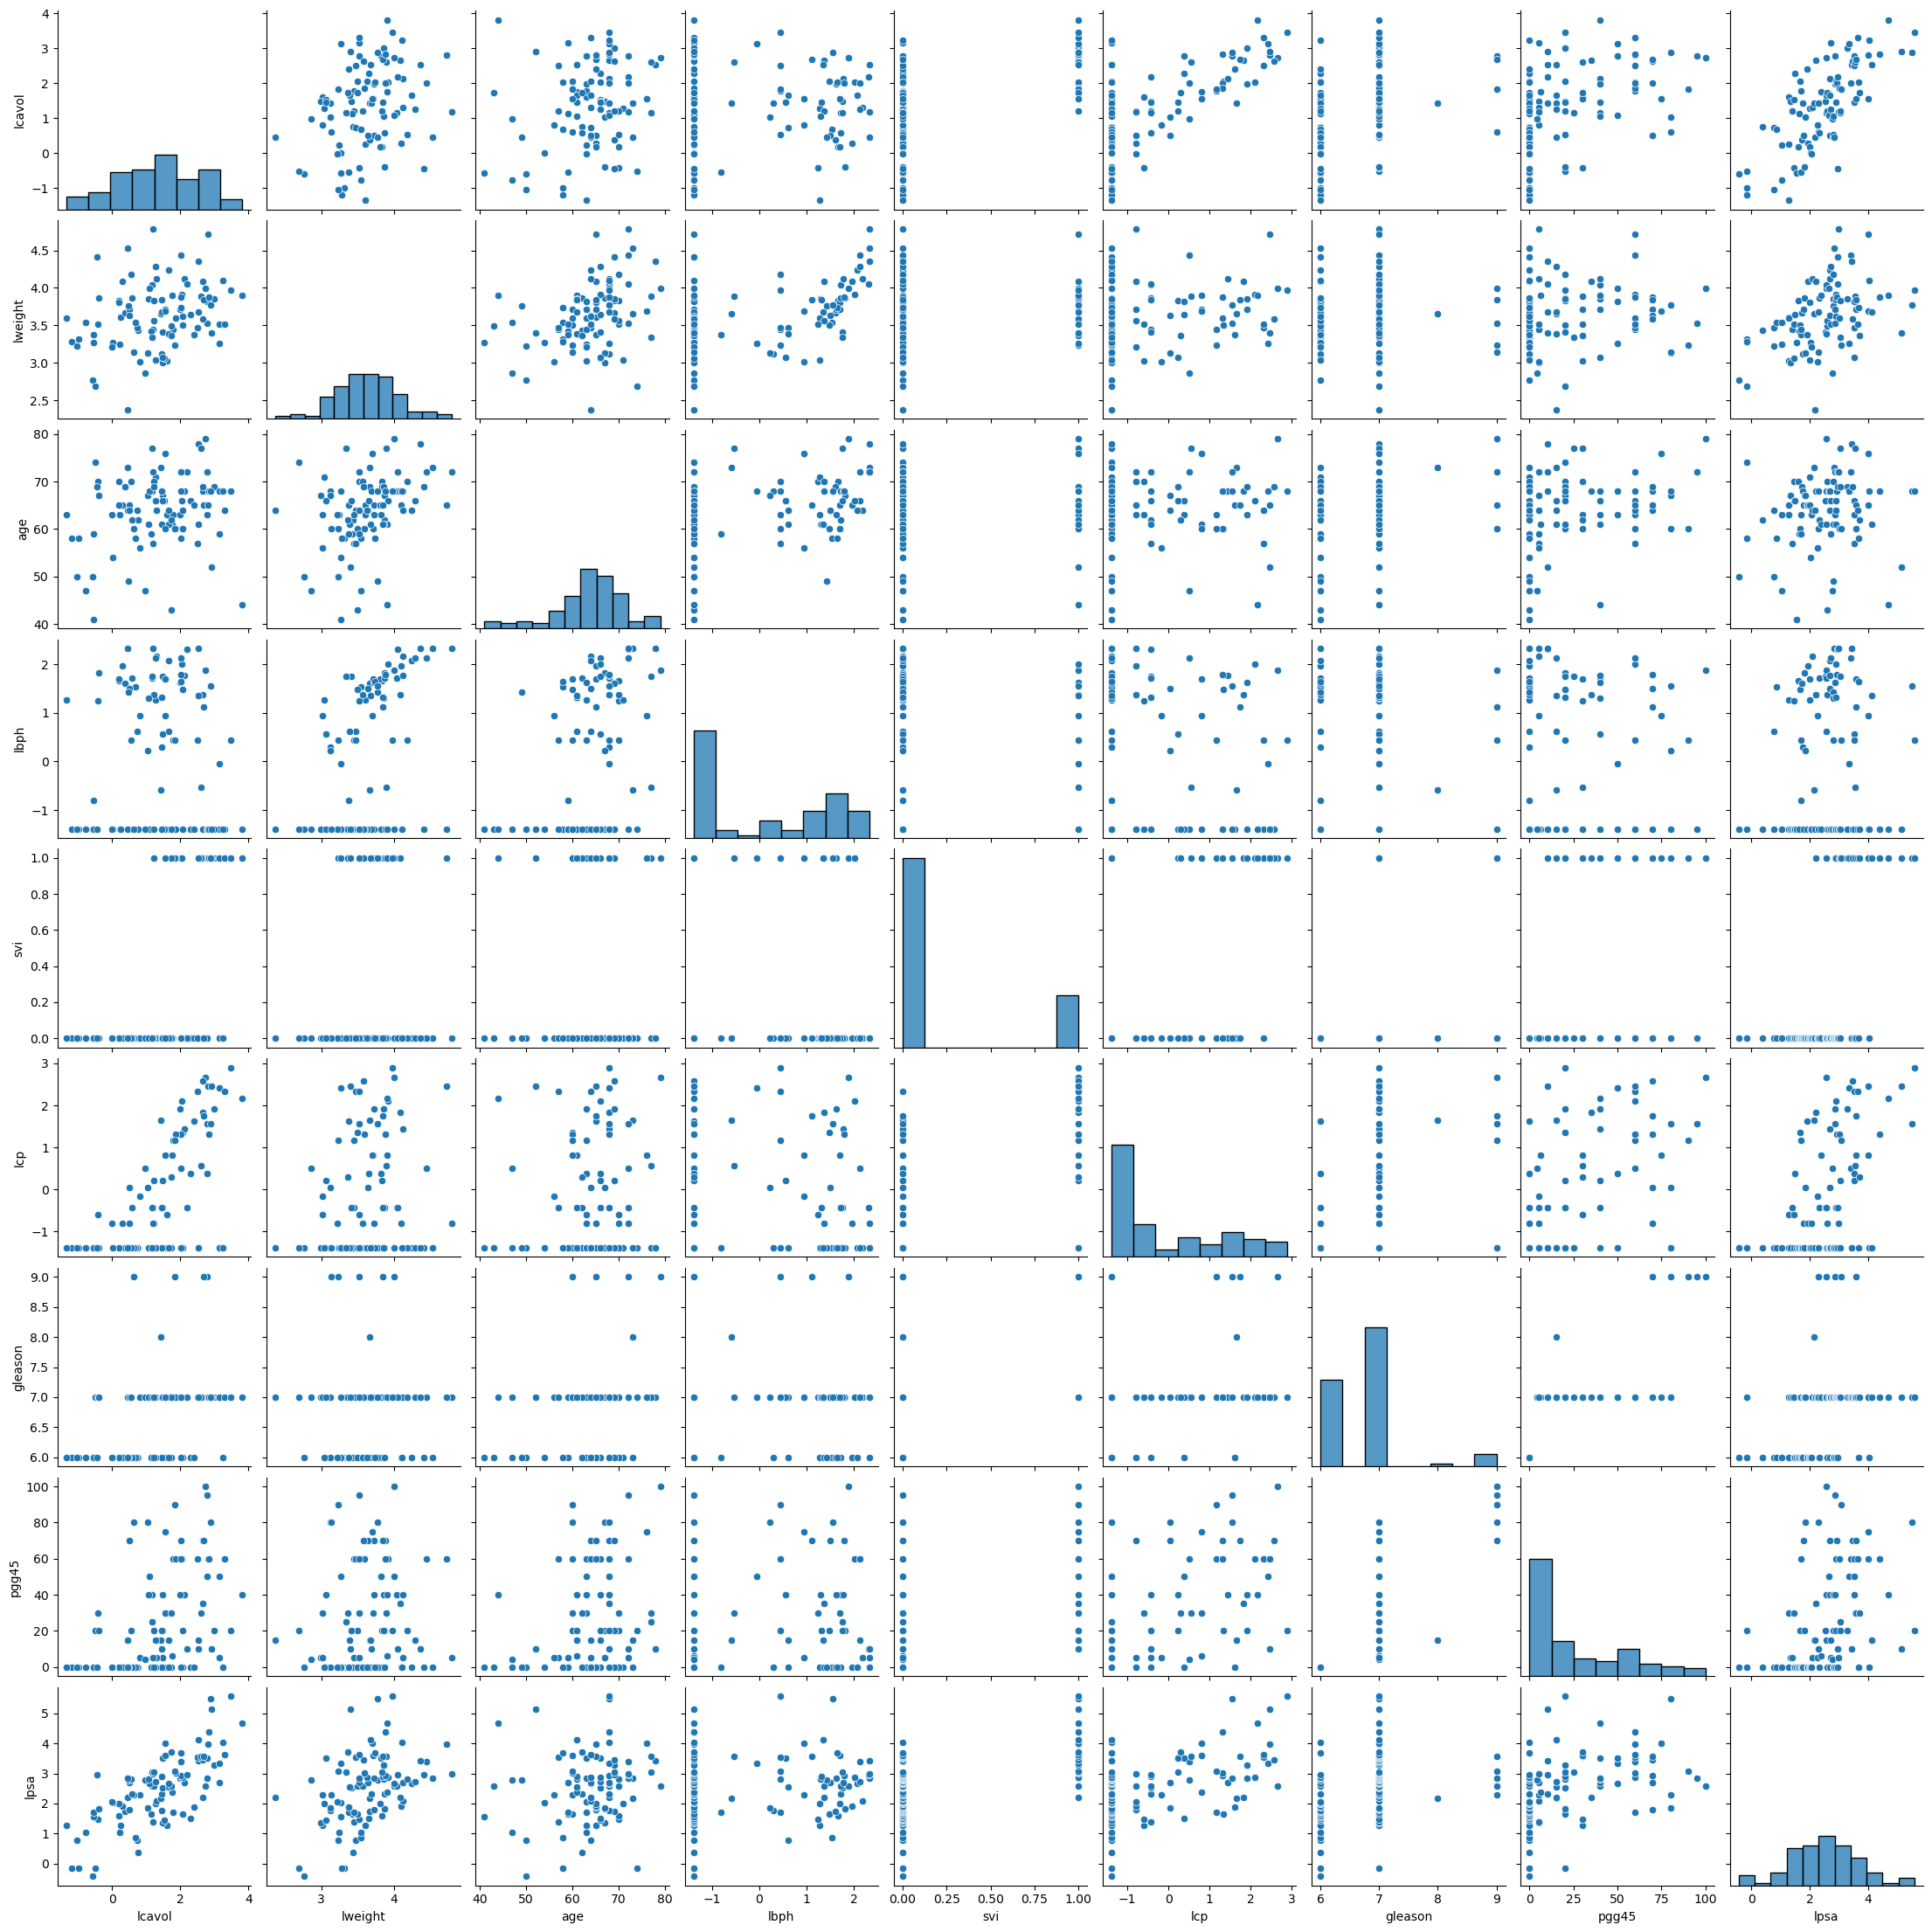

lpsa       1.000000
lcavol     0.734460
svi        0.566218
lcp        0.548813
lweight    0.433319
pgg45      0.422316
gleason    0.368987
lbph       0.179809
age        0.169593
Name: lpsa, dtype: float64


In [6]:
# Code for your answer here!
# part a)
print(prostate.info())
print(prostate.describe())
sns.pairplot(prostate.drop(columns=['train']))
plt.show()

# part b)
correlation_matrix = prostate.corr(numeric_only=True)
print(correlation_matrix['lpsa'].sort_values(ascending=False))

_Part a): svi (Seminal Vesicle Invasion): This appears to be binary/categorical (values are likely 0 or 1). gleason (Gleason Score): This appears to be ordinal. While numeric, Gleason scores are discrete grades (typically 6, 7, 8, 9) representing cancer aggressiveness, not a continuous scale. train: This is categorical (T/F) but is used for data splitting, not as a model feature.\
Part b): The variable lcavol (log cancer volume) typically has the strongest positive correlation with lpsa. You should see this clearly in your pair plot (a relatively linear upward trend) and the correlation matrix (highest value close to 1). Why use lpsa (log of PSA) instead of just PSA?Skewness: Biological markers like PSA (Prostate-Specific Antigen) often follow a log-normal distribution (right-skewed). Most values are low, but a few are extremely high.Linearity: Linear regression assumes a linear relationship between features and the target. Raw PSA values would likely show an exponential relationship with variables like cancer volume. Taking the log ($log(y)$) stabilizes the variance and makes the relationship more linear, satisfying the assumptions of Ordinary Least Squares (OLS) regression._

## Train-Test Set <a id='gen'></a>

For these data we have already been provided a column to indicate which values should be used for the training set and which for the test set. This is encoded by the values in the `train` column - we can use these columns to separate our data and generate our training data: `X_train` and `y_train` as well as our test data `X_test` and `y_test`. 

In [7]:
# Create train and test data frames
train = prostate.query("train == 'T'").drop('train', axis=1)
test = prostate.query("train == 'F'").drop('train', axis=1)

In [8]:
# Training data
X_train = train.drop(['lpsa'], axis=1)
y_train = train.lpsa

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train: (67, 8)
y_train: (67,)


In [9]:
# Test data
X_test = test.drop('lpsa', axis=1)
y_test = test.lpsa

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_test: (30, 8)
y_test: (30,)


Let's also fix the random seed to make this notebook's output identical at every run

In [10]:
# Fix seed
rng = np.random.seed(0)

# Baseline model<a id='baseline'></a>

Our first task is to fit a baseline model which we will be able to use as a point of comparison for our subsequent models. A good candidate for this is a simple linear regression model that includes all of our features.

In [11]:
# Train a linear regression model
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train, y_train)

Using our helper function, we can extract the coefficients for the model, which correspond to the variables: `lcavol`, `lweight`, `age`, `lbph`, `svi`, `lcp`, `gleason`, and `pgg45` respectively.

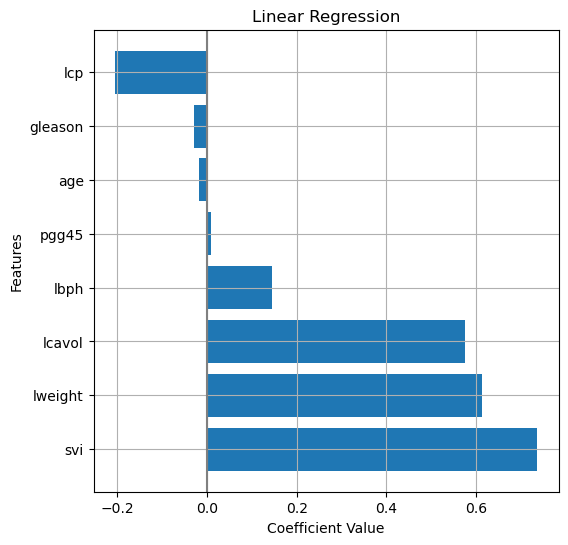

In [12]:
w_df = get_coefs(lm, plot=True, figsize=(6,6), figtitle="Linear Regression", intercept=False)

These coefficients have the typical regression interpretation, e.g. for each unit increase in `lcavol` we expect `lpsa` to increase by 0.5765 on average. To evaluate the predictive properities of our model, we will use the `model_fit` helper function.

### 🚩 Exercise 2 (CORE)

Use the `model_fit` function to evaluate both the model fit on the training data and the predictions on the test data. 

- Based on these plots do you see anything in the fit or residual plot that is potentially concerning? 
- Do you expect the MSE on test data to be better or worse than the MSE on the training data?

--- Training Data Performance ---


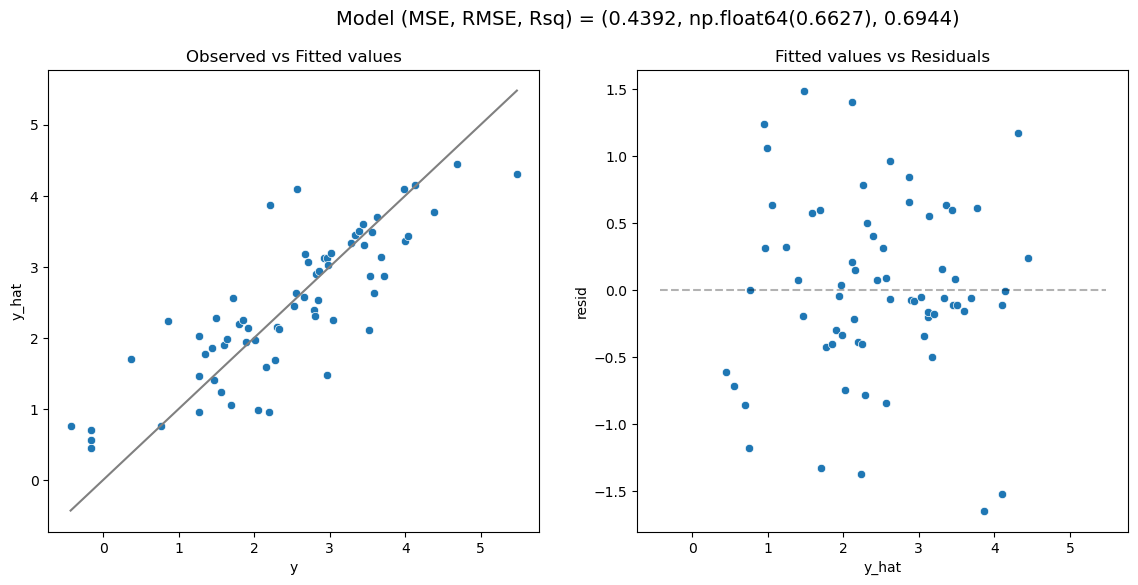


--- Test Data Performance ---


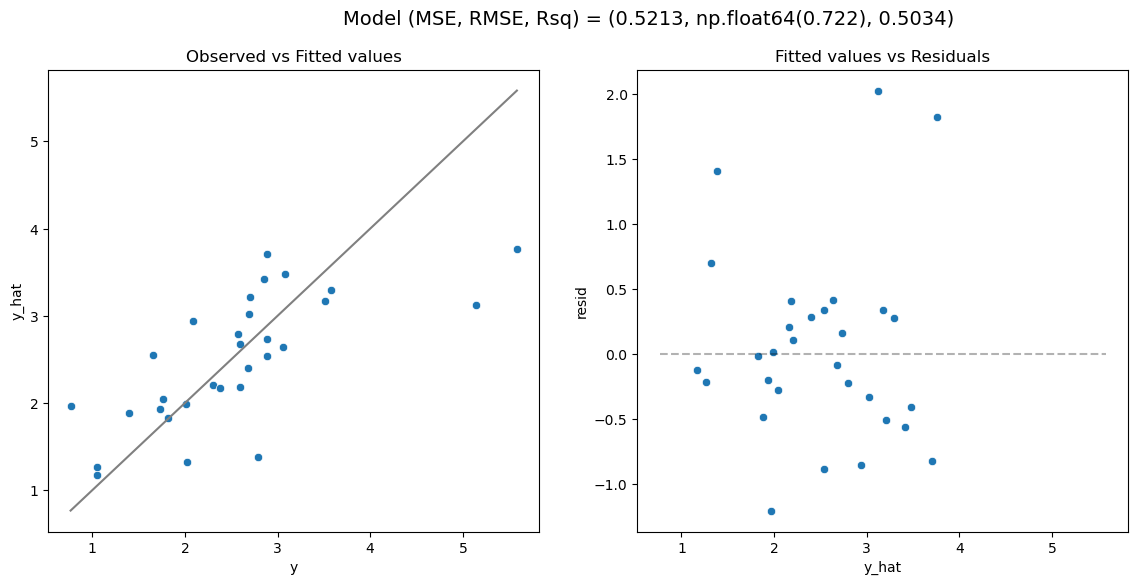

In [13]:
# Code for your answer here!
# Evaluate on Training Data
print("--- Training Data Performance ---")
mse_train, rmse_train, r2_train = model_fit(lm, X_train, y_train, plot=True)

# Evaluate on Test Data
print("\n--- Test Data Performance ---")
mse_test, rmse_test, r2_test = model_fit(lm, X_test, y_test, plot=True)

_Question 1): The plots look generally healthy, with no major alarm bells. This is due to Linearity: In the Fitted values vs Residuals plot (right-hand side), the points are scattered randomly around the dashed zero line. There is no obvious "U-shape" or curve, which implies that a linear model is a decent choice for this data and Homoscedasticity: The vertical spread of residuals is fairly consistent across the graph. There isn't a strong "funnel shape" (where errors get much wider as predictions get larger), though there is slight variation. Outliers: There are no extreme outliers far from the cluster (e.g., a residual of +/- 5 or 10) that would completely skew the regression line.\
Question 2): We expect the Test MSE to be worse. My results confirm this expectation.Training MSE: 0.4392 (Lower error, better fit)Test MSE: 0.5213 (Higher error, worse fit)Reasoning: The model "learned" from the training data, minimizing error specifically for those points. The test data is unseen, so the model naturally performs slightly worse. The significant drop in $R^2$ (from ~0.69 on train to ~0.50 on test) suggests the model might be slightly overfitting—capturing noise in the training set that doesn't apply to the test set._

## Standardization

In subsequent sections we will be exploring the use of the Ridge and Lasso regression models which both penalize larger values of $\mathbf{w}$. While not particularly bad, our baseline model had coefficients that ranged from the smallest at 0.0095 to the largest at 0.737 which is about a 78x difference in magnitude. This difference can be made even worse if we were to change the units of one of our features, e.g. changing a measurement in kg to grams would change that coefficient by 1000 which has no effect on the fit of our linear regression model (predictions and other coefficients would be unchanged) but would have a meaningful impact on the estimates given by a Ridge or Lasso regression model, since that coefficient would now dominate the penalty term.

To deal with this issue, the standard approach is to standaridize all features. Additionally, the feature values can now be interpreted as the number of standard deviations each observation is away from that column's mean.
Using `sklearn` we can perform this transformation using the `StandardScaler` transformer from the preprocessing submodule.

Keep in mind, that in order to avoid **data leakage** and get a realistic idea of the performance of model on the test data, **the mean and standard deviation used to standardize both the training and test sets should be computed from the training data only**.  The best way to accomplish this is to include the StandardScaler in a modeling pipeline for your data

### 🚩 Exercise 3 (CORE)

Consider the following pipeline that first standardizes the numeric features before linear regression. Fit the model to the training data.  Using this new model what has changed about our model results? Comment on both the model's coefficients as well as its predictive performance. How has the interpretation of coefficients changed?

In [14]:
# Linear regression pipeline, including standardization
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# Names of numeric features
num_features = ['lcavol','lweight','age', 'lbph','lcp', 'pgg45']
# Names of binary features
bin_features = ['svi']
ord_features = ['gleason']

preprocessor = make_column_transformer(
    (StandardScaler(), num_features),
    (OrdinalEncoder(categories=[[6,7,8,9]]),ord_features),
    ('passthrough', bin_features),
    verbose_feature_names_out=False
)

lm_s = make_pipeline(
    preprocessor,
    LinearRegression()
).fit(X_train, y_train)

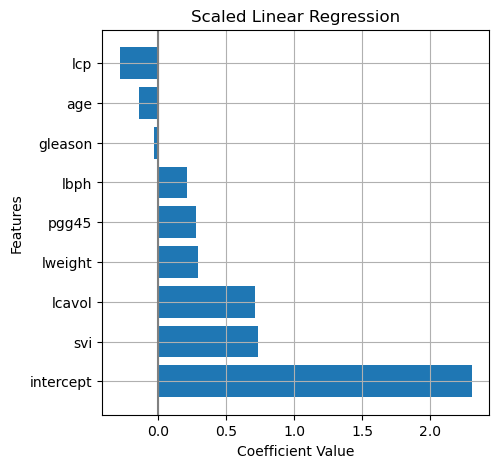

(0.5212740055076002, np.float64(0.7219930785731953), 0.5033798502381809)

In [15]:
# Code for your answer here!
get_coefs(lm_s, plot=True, figtitle="Scaled Linear Regression")

# Evaluate performance on Training Data
model_fit(lm_s, X_train, y_train)

# Evaluate performance on Test Data
model_fit(lm_s, X_test, y_test)

_Q1: Predictive Performance: Nothing has changed. We notice that the MSE and $R^2$ values for both training and test sets are identical to the unscaled model from Exercise 2. For standard Ordinary Least Squares (OLS) regression, scaling the features does not change the "fit" of the line; it only stretches or shrinks the axes. The model finds the exact same optimal hyperplane.Coefficients: These have changed significantly.The values of the coefficients ($\mathbf{w}$) are different. Previously, they depended on the units of the variable (e.g., volume vs. weight). Now, they are on a similar scale.\
Q2: Old Interpretation (Unscaled): "For a 1-unit increase in variable X, the target increases by $w$.".New Interpretation (Scaled): "For a 1 standard deviation increase in variable X, the target increases by $w$."Benefit: We can compare coefficients directly to see which feature is "most important." A larger absolute coefficient now actually means a stronger relationship with the target, regardless of the original units._

# Ridge Regression<a id='ridge'></a>

Ridge regression is a natural extension to linear regression which introduces an $\ell_2$ penalty on the coefficients in a standard least squares problem. 

The [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) model is provided by the `linear_model` submodule. Note that the penalty parameter (referred to as $\lambda$ in the lecture notes) is called `alpha` is sklearn, and, as discussed in lectures, this parameter crucially determines the amount of shrinkage towards zero and the weight of the $\ell_2$ penalty.

After defining the ridge regression model via, e.g. `Ridge(alpha = 1)`, the usual methods can be called, such as `.fit()` to fit the model and `.predict()` to make predictions. 

As for the `LinearRegression()`, after fitting, the intercept and coefficients are stored separately in the attributes `.intercept_` and `.coef_`. In Ridge, this is helpful as it highlights how the penalty is only applied to the coefficient (i.e. we do not want to shrink the intercept).  

Let's start by fitting a ridge regression model with $\alpha=1$.

In [16]:
from sklearn.linear_model import Ridge

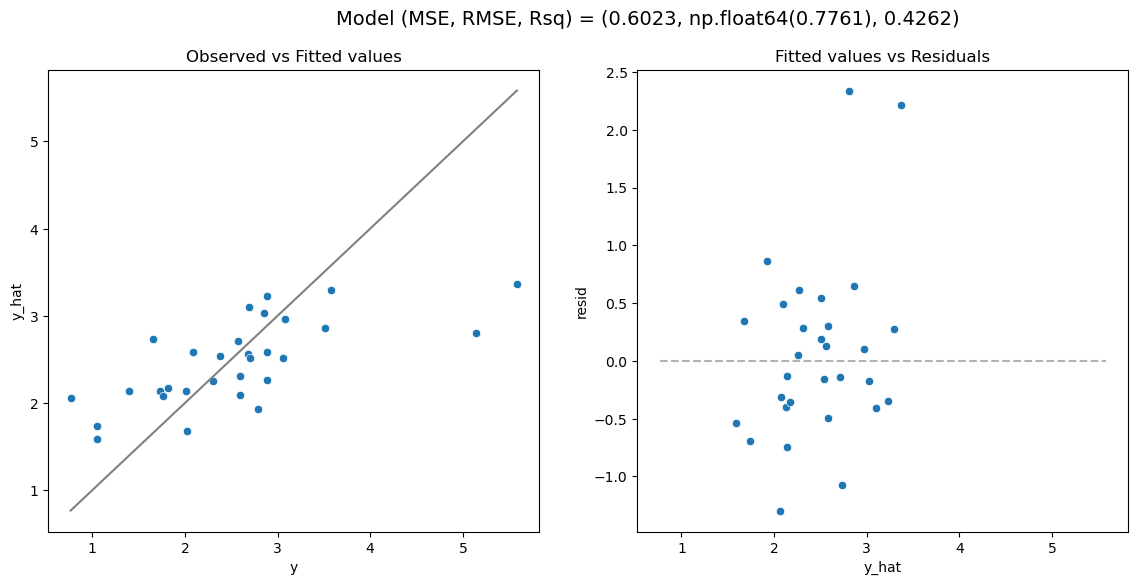

(0.6022994181435168, np.float64(0.776079517925526), 0.4261865658376307)

In [17]:
# Selected alpha value 
# Selected alpha value 
alpha_val = 100

# Ridge pipeline
r = make_pipeline(
    preprocessor,
    Ridge(alpha = alpha_val)
).fit(X_train, y_train)

model_fit(r, X_test, y_test, plot = True)

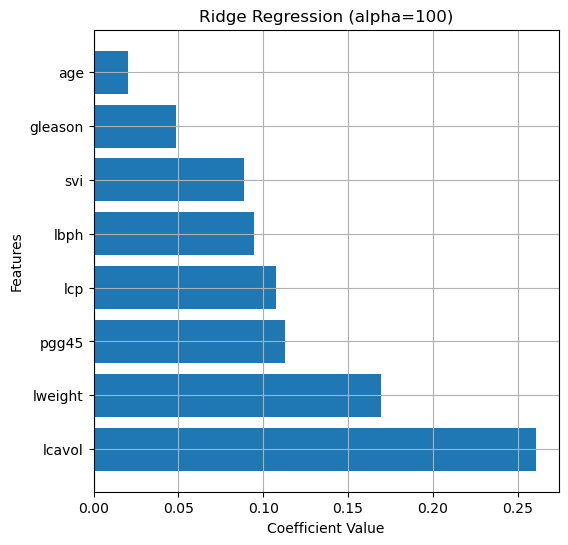

In [18]:
w_dr_r = get_coefs(r, plot=True, figsize=(6,6), figtitle="Ridge Regression (alpha="+str(alpha_val)+")", intercept=False)

### 🚩 Exercise 4 (CORE)

Adjust the value of `alpha` in the cell above and rerun it. Qualitatively, how does the model fit change as alpha changes? How does the MSE change? 


_Small Alpha (e.g., 0.01): The model behaves almost exactly like standard Linear Regression. The line will try to pass through as many training points as possible. The coefficients will be large.Large Alpha (e.g., 100): The model becomes "stiff." The regularization penalty dominates, forcing the coefficients ($\mathbf{w}$) to shrink towards zero.Visual result: The regression line becomes flatter (closer to a horizontal line). It ignores the fluctuations in the data because "reacting" to them requires large coefficients, which are now expensive.\
Training MSE: As alpha increases, Training MSE increases (gets worse). Test MSE: As alpha increases, Test MSE usually improves (decreases) up to a point, and then gets worse._


## Solution path: Ridge coeffcients as a function of $\alpha$

A useful way of examining the behavior of Ridge regression models is to plot the **solution path** of the coefficents $\mathbf{w}$ as a function of the penalty parameter $\alpha$. Since Ridge regression is equivalent to linear regression when $\alpha=0$, we can see that as we increase the value of $\alpha$, we are shrinking all of the coefficients in $\mathbf{w}$ towards zero asymptotically $\alpha$ approaches infinity.

In [19]:
# Grid of alpha values
alphas = np.logspace(-2, 3, num=200) # from 10^-2 to 10^3

ws = [] # Store coefficients
mses_train = [] # Store training mses
mses_test = [] # Store test mses

for a in alphas:
    m = make_pipeline(
        preprocessor,
        Ridge(alpha=a)
    ).fit(X_train, y_train)
    
    ws.append(m[-1].coef_) 
    mses_train.append(mean_squared_error(y_train, m.predict(X_train)))
    mses_test.append(mean_squared_error(y_test, m.predict(X_test)))


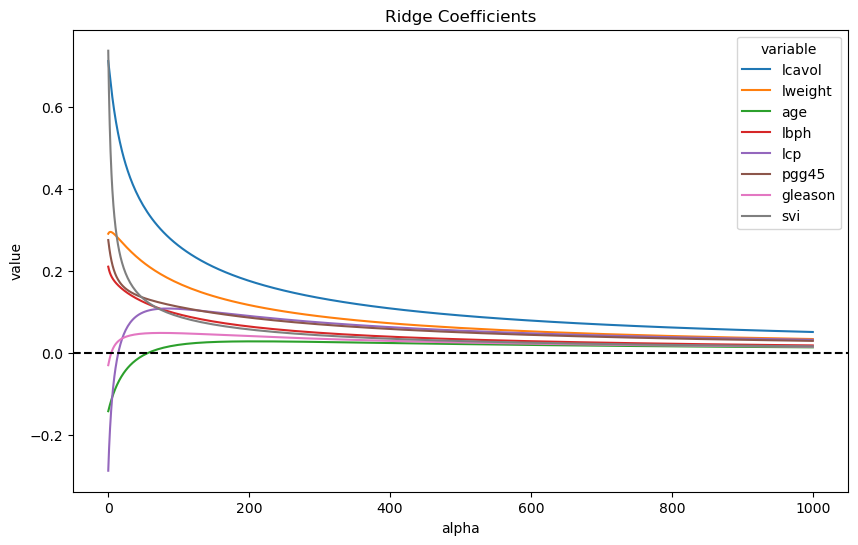

In [20]:
# Create a data frame for plotting
sol_path = pd.DataFrame(
    data = ws,
    columns = m[0].get_feature_names_out()
).assign(
    alpha = alphas,
).melt(
    id_vars = ('alpha')
)

# Plot solution path of the weights
plt.figure(figsize=(10,6))
ax = sns.lineplot(x='alpha', y='value', hue='variable', data=sol_path)
ax.axhline(y=0, color = "black", linestyle='dashed')
ax.set_title("Ridge Coefficients")
plt.show()

### 🚩 Exercise 5 (CORE)

Based on this plot, which variable(s) seem to be the most important for predicting `lpsa`?

_The most important variable is lcavol (Log Cancer Volume).Reasoning:Visual Evidence: In your plot, the blue line representing lcavol starts with the highest coefficient value (at $\alpha = 0$) and remains the highest line throughout the entire graph as $\alpha$ increases.Interpretation: This indicates that even when we apply a strong penalty to the model (forcing it to simplify), it "fights" to keep the coefficient for lcavol large. This implies that lcavol carries the most unique and essential information for predicting the target (lpsa).Secondary Mentions:The variable svi (Seminal Vesicle Invasion, likely the grey line) is the second most important initially, as it starts with the second-highest magnitude, though it shrinks somewhat quickly.The variable lweight (Log Prostate Weight, the orange line) is also consistently relevant, though with a smaller magnitude than lcavol._

### 🚩 Exercise 6 (CORE)

Run the code below to also plot both the training and test MSE as a function of $\alpha$. What do you notice about the MSE as we increase $\alpha$? Which value of $\alpha$ seems better regarding the changes on training and testing MSE values?

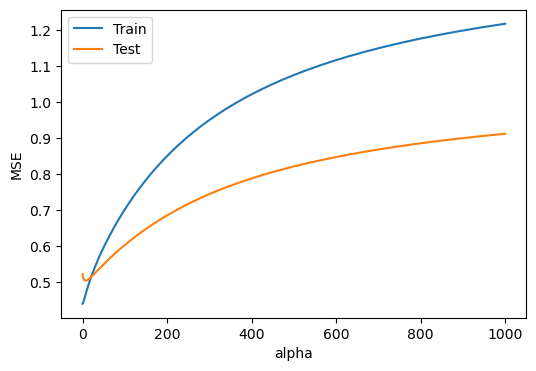

In [22]:
# Path of MSE as function of alpha
mses_path = pd.DataFrame(
    {'alpha': alphas, 'Train': np.asarray(mses_train), 'Test': np.asarray(mses_test)}).melt(
    id_vars = ('alpha')
)

# Plot MSE path
plt.figure(figsize=(6,4))
ax = sns.lineplot(x='alpha', y='value', hue='variable', data=mses_path)
ax.set_ylabel("MSE")
# ax.set_xlim(0,200) # Optional: to zoom in on lower alpha values
# To remove legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
plt.show()


_Training MSE: It increases steadily. As $\alpha$ gets larger, the penalty term dominates. The model is forced to shrink its coefficients toward zero, restricting its freedom to fit the training data. This leads to higher "bias" and a worse fit on the data it has already seen.Test MSE: It follows a similar upward trend for most of the graph. While some regularization usually helps, this plot shows that adding too much regularization (large $\alpha$) causes the model to "underfit." It becomes too simple to capture the complexity of the data, so the error on the test set increases.\
A very small value (close to 0) appears best in this specific plot. Observation: The orange line (Test MSE) is at its lowest point at the far left of the x-axis. As we move to the right, the error only gets higher._

## Tuning the penalty parameter with cross-validation

We see that the value of $\alpha$ crucially determines the performance of the ridge regression model. While `RidgeRegression()` uses the default value of `alpha=1`, this **should never be used in practice**. Instead, this parameter can be **tuned using cross-validation**. 

As with the polynomial models from last week, we can use `GridSearchCV` to employ k-fold cross validation to determine an optimal $\alpha$. Remember, you can use the method `.get_params()` on your pipeline to list the parameters names to specify in `GridSearchCV`.

In [24]:
# Grid of tuning parameters
alphas = np.linspace(0, 30, num=201)  

#Pipeline
m = make_pipeline(
        preprocessor,
        Ridge())
# To get the parameter name for grid search
# m.get_params()

# CV strategy
cv = KFold(5, shuffle=True, random_state=1234)

# Grid search
gs = GridSearchCV(m,
    param_grid={'ridge__alpha': alphas},
    cv=cv,
    scoring="neg_mean_squared_error")
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['lcavol',
                                                                          'lweight',
                                                                          'age',
                                                                          'lbph',
                                                                          'lcp',
                                                                          'pgg45']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[[6,
                                                                                                     7,
                                                                                                     8,
                                                                                                     9]]),
                                                                         ['gleason']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['svi'])],
                                                          verbose_featu...
       20.25, 20.4 , 20.55, 20.7 , 20.85, 21.  , 21.15, 21.3 , 21.45,
       21.6 , 21.75, 21.9 , 22.05, 22.2 , 22.35, 22.5 , 22.65, 22.8 ,
       22.95, 23.1 , 23.25, 23.4 , 23.55, 23.7 , 23.85, 24.  , 24.15,
       24.3 , 24.45, 24.6 , 24.75, 24.9 , 25.05, 25.2 , 25.35, 25.5 ,
       25.65, 25.8 , 25.95, 26.1 , 26.25, 26.4 , 26.55, 26.7 , 26.85,
       27.  , 27.15, 27.3 , 27.45, 27.6 , 27.75, 27.9 , 28.05, 28.2 ,
       28.35, 28.5 , 28.65, 28.8 , 28.95, 29.1 , 29.25, 29.4 , 29.55,
       29.7 , 29.85, 30.  ])},
             scoring='neg_mean_squared_error')

Note that we are passing `sklearn.model_selection.KFold(5, shuffle=True, random_state=1234)` to the `cv` argument rather than leaving it to its default. This is because, while not obvious, the prostate data is structured (sorted by `lpsa` value) and this way we are able to ensure that the folds are properly shuffled. Failing to do this causes *very* unreliable results from the cross validation process.

Once fit, we can examine the results to determine what value of $\alpha$ was chosen as well as examine the results of cross validation.

In [25]:
print(gs.best_params_)
print(-gs.best_score_)

{'ridge__alpha': np.float64(1.05)}
0.7113777058489015


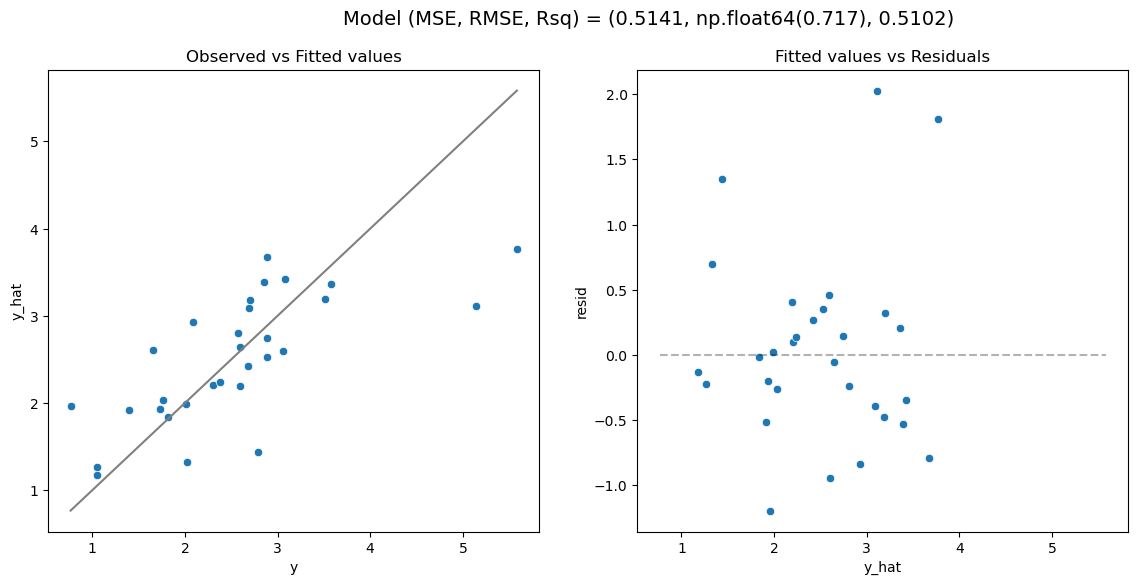

(0.5141325717194644, np.float64(0.7170303840978179), 0.5101835271526369)

In [26]:
model_fit(gs.best_estimator_, X_test, y_test, plot=True)

### 🚩 Exercise 7 (CORE)

- How does this model compare to the performance of our baseline model? Is it better or worse?

- How do the model coefficients for this model compare to the baseline model? To answer this, create a scatter plot of the coefficients for the baseline model against the coefficients for the ridge model. Are they always higher or lower? Now, use `np.linalg.norm` to compute the $\ell_2$ norm of the coeffcients for both models and comment on the results. 

_The tuned Ridge model is slightly better than the baseline model.The Test MSE decreased (error went down from ~0.521 to ~0.514).The Test $R^2$ increased (explained variance went up from ~50.3% to ~51.0%).\
The Ridge norm is smaller. This confirms that the regularization worked. By adding the penalty term $\alpha ||\mathbf{w}||^2_2$ to the loss function, the model was forced to "shrink" the coefficient vector to find a solution that is both accurate and "shorter" (less complex).For the large positive coefficients (top right), the dots fall slightly below the red dashed line. For the negative coefficients (bottom left), the dots fall slightly above the red dashed line. In both cases, the values are being pulled closer to zero (the center of the graph). This is visual proof of the "shrinkage" effect. The model trades a tiny bit of training accuracy for smaller, more stable coefficients._

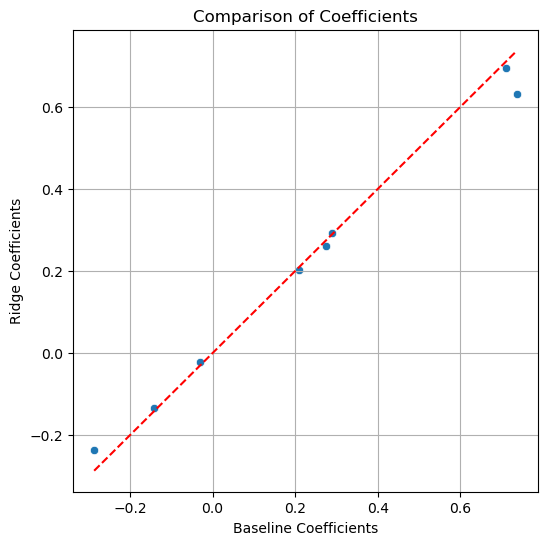

L2 Norm (Baseline): 1.1647
L2 Norm (Ridge):    1.0723


In [27]:
# Code for your answer here!
# Extract coefficients
# Baseline coefficients
coefs_baseline = lm_s[-1].coef_ 

# Ridge coefficients
coefs_ridge = gs.best_estimator_[-1].coef_

# Create Scatter Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=coefs_baseline, y=coefs_ridge)
# Add a diagonal line for reference (x=y)
plt.plot([min(coefs_baseline), max(coefs_baseline)], 
         [min(coefs_baseline), max(coefs_baseline)], 
         color='red', linestyle='--')
plt.xlabel("Baseline Coefficients")
plt.ylabel("Ridge Coefficients")
plt.title("Comparison of Coefficients")
plt.grid(True)
plt.show()

# Compute L2 Norms
norm_baseline = np.linalg.norm(coefs_baseline)
norm_ridge = np.linalg.norm(coefs_ridge)

print(f"L2 Norm (Baseline): {norm_baseline:.4f}")
print(f"L2 Norm (Ridge):    {norm_ridge:.4f}")

As we saw last week, it is also recommend to plot the CV scores. Although the grid search may report a best value for the parameter corresponding to the maximum CV score (e.g. min CV MSE), if the curve is relatively flat around the minimum, we prefer the simpler model. 

Recall from last week that we can access the cross-validated scores (along with other results for each split) in the attribute `cv_results_`. 

In [30]:
cv_results = pd.DataFrame(gs.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003541,0.000452,0.002102,0.000249,0.00,{'ridge__alpha': 0.0},-0.933523,-0.684212,-0.732690,-0.424796,-0.789296,-0.712903,0.166571,20
1,0.002859,0.000090,0.001717,0.000029,0.15,{'ridge__alpha': 0.15},-0.936583,-0.689944,-0.730721,-0.419826,-0.785028,-0.712420,0.168506,16
2,0.002874,0.000171,0.001953,0.000341,0.30,{'ridge__alpha': 0.3},-0.939497,-0.695286,-0.729046,-0.415606,-0.780848,-0.712057,0.170243,13
3,0.003496,0.000419,0.002042,0.000201,0.45,{'ridge__alpha': 0.44999999999999996},-0.942272,-0.700271,-0.727639,-0.412013,-0.776750,-0.711789,0.171809,10
4,0.003530,0.000252,0.002126,0.000344,0.60,{'ridge__alpha': 0.6},-0.944917,-0.704931,-0.726475,-0.408949,-0.772727,-0.711600,0.173226,8


In particular, let's examining the `mean_test_score` and the `split#_test_score` keys since these are used to determine the optimal $\alpha$.

In the code below we extract these data into a data frame by selecting our columns of interest along with the $\alpha$ values used (and transform negative MSE values into positive values).

In [31]:
# Extract only mean and split scores
cv_mse = pd.DataFrame(
    data = gs.cv_results_
).filter(
    # Extract the split#_test_score and mean_test_score columns
    regex = '(split[0-9]+|mean)_test_score'
).assign(
    # Add the alphas as a column
    alpha = alphas
)

cv_mse.update(
    # Convert negative mses to positive
    -1 * cv_mse.filter(regex = '_test_score')
)

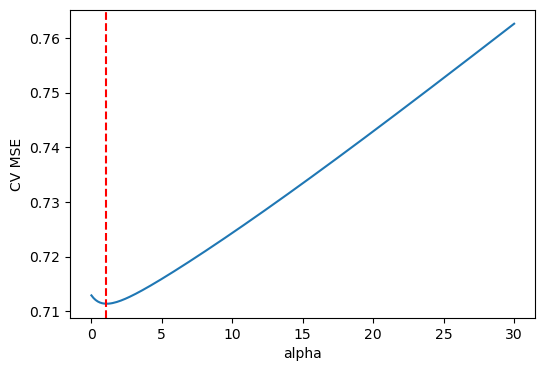

In [32]:
# Plot CV MSE
plt.figure(figsize=(6,4))
ax = sns.lineplot(x='alpha', y='mean_test_score', data=cv_mse)
ax.set_ylabel('CV MSE')
ax.axvline(x=gs.best_params_['ridge__alpha'], color='red', linestyle='dashed', label='Best alpha')
plt.show()

This plot shows that the value of $\alpha=1.05$ corresponds to the minimum of this curve. However, this plot gives us an overly confident view of this particular value of $\alpha$. Specifically, if instead of just plotting the mean MSE across all of the validation sets, we also examine the MSE for each fold individually and the corresponding optimal value of $\alpha$, we see that there is a lot of noise in the MSE and we should take the value $\alpha = 1.05$ with a grain of salt.

### 🚩 Exercise 8 (CORE)

Run the code below to plot the MSE for each validation set in the 5-fold cross validation. Why do you think that our cross validation results are unstable?

In [ ]:
# Reshape the data frame for plotting
d = cv_mse.melt(
    id_vars=('alpha','mean_test_score'),
    var_name='fold',
    value_name='MSE'
)

# Plot the validation scores across folds
plt.figure(figsize=(6,4))
sns.lineplot(x='alpha', y='MSE', color='black', errorbar=None, data = d)  # Plot the mean MSE in black.
sns.lineplot(x='alpha', y='MSE', hue='fold', data = d) # Plot the curves for each fold in different colors
plt.show()

_Type your answer here_

### 🚩 Exercise 9 (CORE)

Lastly, try changing the random seed in the cross-validation scheme. Plot the CV MSE with the optimal value of alpha marked with a vertical dashed line. How do the results change? Are different values of `alpha` suggested? Comment on your preffered value of `alpha`.

In [ ]:
# CV strategy
cv = KFold(5, shuffle=True, random_state=0)

# Code for your answer here!

_Type your answer here_

*Note:* Due to the importance of tuning the value of $\alpha$ in ridge regression, sklearn provides a function called [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) which combines `Ridge` with `GridSearchCV`. However, we will avoid using this function for two reasons:

- it does not allow us to account for additional steps in our pipeline such as standardization when carrying out cross validation, resulting in _data leakage_
- it only allows storing all results of the cross-validation in the attribute `.cv_results_` in the case of the default leave-one-out cross validation, with option `store_cv_results=True`. So, if you want to access all results and use a cross-validation strategy other than leave-one-out, you will need to use `GridSearchCV`. 

# Lasso Regression<a id='lasso'></a>

We saw that ridge regression with a wise choice of $\alpha$ can outperform our baseline linear regression. We can now investigate if lasso can yield a more accurate or interpretable solution. Recall that lasso uses an $\ell_1$ penalty on the coefficients, as opposed to the $\ell_2$ penalty of ridge. 

The [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) model is also provided by the `linear_model` submodule and similarly requires the choice of the tuning parameter `alpha` to determine the weight of the $\ell_1$ penalty. 

Try running the code below with different values of $\alpha$ to see how it effects sparsity in the coefficients and model performance.

In [ ]:
from sklearn.linear_model import Lasso

# Selected alpha value 
alpha_val = 0.15

# Lasso pipeline
l = make_pipeline(
    preprocessor,
    Lasso(alpha = alpha_val)
).fit(X_train, y_train)

model_fit(l, X_test, y_test, plot = True)

In [ ]:
w_dr_r = get_coefs(l, plot=True, figsize=(6,6), figtitle="Lass Regression (alpha="+str(alpha_val)+")", intercept=False)

### 🚩 Exercise 10 (CORE)

a) Plot the solution path of the coefficients as a function of $\alpha$.

b) How does this differ between the solution path for Ridge for large $\alpha$? for small $\alpha$?

c) Which variable seems to be the most important for predicting `lpsa`?

*Note that $\alpha = 0$ causes a warning due to the fitting method (coordinate descent) not converging well without regularization (the $\ell_1$ penalty here). So, the grid of $\alpha$ values needs to start at some small positive constant.*

In [ ]:
# Code for your answer here!

_Type your answer here_

## Tuning the Lasso penalty parameter

Again, we can use the `GridSearchCV` function to tune our Lasso model and optimize the $\alpha$ hyperparameter. You could also use [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html), which combines `Lasso` and `GridSearchCV` but we will focus on the former to avoid _data leakage_. 

### 🚩 Exercise 11 (CORE)

a) Use `GridSearchCV` to find the optimal value of $\alpha$.  

b) Plot the CV MSE and MSE for each fold. Comment on the stability and uncertainty of $\alpha$ across the different folds. Try changing the value of the `random_state` in the CV strategy - do the results change? are they more or less stable compared with ridge?

c) Which variables are included with this optimal value of $\alpha$?

In [ ]:
# Code for your answer here!

_Type your answer here_

### 🚩 Exercise 12 (CORE)

Run the following code to compute the CV MSE for the linear model and compare with the CV MSE of the lasso model to suggest an optimal value of $\alpha$.

In [ ]:
# Lasso doesn't allow for alpha=0, so compute CV MSE for linear regression model to compare with Lasso
gs_l = GridSearchCV(
    make_pipeline(
        preprocessor,
        LinearRegression()
    ),
    param_grid = {},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_mean_squared_error"
).fit(X_train, y_train)

In [ ]:
# Code for your answer here!

_Type your answer here_

# ElasticNet Regression<a id='elasticnet'></a>

Lastly, we can use elastic net regression, which is hybrid between lasso and ridge, including both an $\ell_1$ and $\ell_2$ penalty. The [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) model is again provided by the `linear_model` submodule and minimizes the objective:
$$ \frac{1}{2N} || \mathbf{y} - \mathbf{X}\mathbf{w} ||^2_2 + \alpha \rho ||\mathbf{w}||_1
+ 0.5 \alpha (1 - \rho) ||\mathbf{w}||^2_2.$$

In this parameterization, $\rho$ determines relative strength of the $\ell_1$ penalty compared to the $\ell_2$ and is referred to as `l1_ratio` in `ElasticNet`. Thus, we can also fit ridge and lasso regression models with `ElasticNet` through appropriate choice of `l1_ratio`:
- ridge corresponds to `l1_ratio=0`
- lasso corresponds to `l1_ratio=1`

The parameter $\alpha$ is referred to as `alpha` in `ElasticNet` and controls the overall penalty relative the residual sum of squares. 

The general `ElasticNet` requires tuning of both `alpha` and `l1_ratio`. 

### 🚩 Exercise 13 (CORE)

The following code plots the solution path for a specific value of `l1_ratio`. Try changing the value of `l1_ratio` (you may also want to change the maximal value of `alpha` for better visualization). How do the solution paths change?

In [ ]:
from sklearn.linear_model import ElasticNet

# Grid of alpha values
alphas = np.linspace(0.01, 1, num=200)
# L1 ratio
l = 1
ws = [] # Store coefficients
mses_train = [] # Store training mses
mses_test = [] # Store test mses

for a in alphas:
    m = make_pipeline(
        preprocessor,
        ElasticNet(alpha=a, l1_ratio=l)
    ).fit(X_train, y_train)
    
    ws.append(m[-1].coef_) 
    mses_train.append(mean_squared_error(y_train, m.predict(X_train)))
    mses_test.append(mean_squared_error(y_test, m.predict(X_test)))

# Create a data frame with the solution path
sol_path = pd.DataFrame(
    data = ws,
    columns = m[0].get_feature_names_out()
).assign(
    alpha = alphas,
).melt(
    id_vars = ('alpha')
)

# Plot the solution path of the weights
plt.figure(figsize=[7,5])
ax = sns.lineplot(x='alpha', y='value', hue='variable', data=sol_path)
ax.set_title(f'Elastic Net with L1 ratio: {l}')
plt.show()

_Type your answer here_

## Tuning with Grid Search CV

Again, we can use `GridSearchCV` (or [`ElasticNetCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)) to tune the parameters. In the following code, we use `GridSearchCV` to tune both `alpha` and `l1_ratio`. 

In [ ]:
# Grid of tuning parameters
alphas = np.linspace(0.01, 5, num=50)
l1r = [0.01, .1, .5, .7, .9, .95, 1]

# CV strategy
cv = KFold(5, shuffle=True, random_state=1234)

# Pipeline
m = make_pipeline(
        preprocessor,
        ElasticNet())

# Grid search
gs_enet = GridSearchCV(m,
                        param_grid={'elasticnet__alpha': alphas, 'elasticnet__l1_ratio': l1r},
                        cv = cv,
                        scoring="neg_mean_squared_error",
                        return_train_score=True)
gs_enet.fit(X_train, y_train)

gs_enet.best_params_

Grid search returns the best value, but to better support these choices, let's plot the cv scores as a function of `alpha` for different values of `l1_ratio`.

In [ ]:
# Extract mean CV scores for each l1_ratio
cv_results_df = pd.DataFrame(gs_enet.cv_results_)
cv_results_df['alpha'] = cv_results_df['param_elasticnet__alpha']
cv_results_df['l1_ratio'] = cv_results_df['param_elasticnet__l1_ratio']

# Convert negative MSE to positive
cv_results_df['mean_cv_mse'] = -cv_results_df['mean_test_score']

# Plot
plt.figure(figsize=(10, 6))
for l1_val in l1r:
    subset = cv_results_df[cv_results_df['l1_ratio'] == l1_val]
    plt.plot(subset['alpha'], subset['mean_cv_mse'], marker='o', label=f'L1 ratio={l1_val}')

plt.axvline(x=gs_enet.best_params_['elasticnet__alpha'], color='red', linestyle='dashed', 
            label=f'Best alpha={gs_enet.best_params_["elasticnet__alpha"]:.4f}')
plt.xlabel('Alpha')
plt.ylabel('CV MSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 🚩 Exercise 14 (CORE)

Comment on the optimal values of `alpha` and `l1_ratio` for ElasticNet based on the plot above. How does the CV MSE of tuned Elastic Net compare to our basineline, ridge, and lasso models? How does the performance of the models compare on the test data?

_Type your answer here_

In [ ]:
# Code for your answer here!

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please **change 'Student 1' and 'Student 2' at the top of the notebook to include your name(s)**.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF.

In [ ]:
!jupyter nbconvert --to pdf mlp_week05.ipynb 